HEART DISEASE DETECTOR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('dataset heart disease.csv')

In [3]:
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [4]:
df = pd.get_dummies(df, drop_first=True)

In [5]:
X = df.drop('target', axis=1).values
y = df['target'].values.reshape(-1, 1)

In [6]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import numpy as np

def gini_index(groups, classes):
    n_instances = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        _, y = zip(*group)
        for class_val in classes:
            p = y.count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[0][index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0][0])):
        for row in dataset:
            groups = test_split(index, row[0][index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[0][index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}


In [9]:
def to_terminal(group):
    outcomes = [row[1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])

    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)


In [10]:
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


In [11]:
import random
from collections import Counter

def subsample(dataset, ratio):
    sample = []
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = random.randrange(len(dataset))
        sample.append(dataset[index])
    return sample

def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return Counter(predictions).most_common(1)[0][0]

def random_forest(train, test, max_depth, min_size, sample_size, n_trees):
    trees = []
    for _ in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)

    predictions = [bagging_predict(trees, row[0]) for row in test]
    actuals = [row[1] for row in test]
    accuracy = sum([1 for i in range(len(predictions)) if predictions[i] == actuals[i]]) / len(actuals)
    print(f" Random Forest Accuracy: {accuracy * 100:.2f}%")
    return predictions, actuals


In [12]:
data = list(zip(X_train, y_train.ravel()))
test = list(zip(X_test, y_test.ravel()))


In [13]:
preds, trues = random_forest(
    train=data,
    test=test,
    max_depth=10,
    min_size=5,
    sample_size=0.8,
    n_trees=10
)


 Random Forest Accuracy: 92.02%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(trues, preds)
precision = precision_score(trues, preds)
recall = recall_score(trues, preds)
f1 = f1_score(trues, preds)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"Random Forest Precision: {precision:.4f}")
print(f"Random Forest Recall: {recall:.4f}")
print(f"Random Forest F1 Score: {f1:.4f}")

print("\nDetailed Classification Report:\n")
print(classification_report(trues, preds))
plt.figure(figsize=(6, 4))  

Random Forest Accuracy: 0.9202
Random Forest Precision: 0.9118
Random Forest Recall: 0.9466
Random Forest F1 Score: 0.9288

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       107
           1       0.91      0.95      0.93       131

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238



<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [17]:
import itertools

def tune_random_forest(train, test, n_trees_list, max_depth_list, min_size_list, sample_size_list):
    best_score = 0
    best_params = None

    for n_trees, max_depth, min_size, sample_size in itertools.product(
        n_trees_list, max_depth_list, min_size_list, sample_size_list):

        preds, trues = random_forest(
            train=train,
            test=test,
            max_depth=max_depth,
            min_size=min_size,
            sample_size=sample_size,
            n_trees=n_trees
        )

        from sklearn.metrics import f1_score
        f1 = f1_score(trues, preds)

        print(f"Trees: {n_trees}, Depth: {max_depth}, Min Size: {min_size}, Sample Size: {sample_size} => F1: {f1:.4f}")

        if f1 > best_score:
            best_score = f1
            best_params = (n_trees, max_depth, min_size, sample_size)

    print(f"\nBest F1 Score: {best_score:.4f} with params: Trees={best_params[0]}, Depth={best_params[1]}, Min Size={best_params[2]}, Sample Size={best_params[3]}")

    return best_params


In [ ]:
train_data = list(zip(X_train, y_train.ravel()))
test_data = list(zip(X_test, y_test.ravel()))

best_params = tune_random_forest(
    train=train_data,
    test=test_data,
    n_trees_list=[5, 10, 15],
    max_depth_list=[5, 10, 15],
    min_size_list=[1, 5, 10],
    sample_size_list=[0.6, 0.8, 1.0]
)


 Random Forest Accuracy: 87.39%
Trees: 5, Depth: 5, Min Size: 1, Sample Size: 0.6 => F1: 0.8872
 Random Forest Accuracy: 86.97%
Trees: 5, Depth: 5, Min Size: 1, Sample Size: 0.8 => F1: 0.8839
 Random Forest Accuracy: 88.24%
Trees: 5, Depth: 5, Min Size: 1, Sample Size: 1.0 => F1: 0.8939
 Random Forest Accuracy: 87.82%
Trees: 5, Depth: 5, Min Size: 5, Sample Size: 0.6 => F1: 0.8930
 Random Forest Accuracy: 85.71%
Trees: 5, Depth: 5, Min Size: 5, Sample Size: 0.8 => F1: 0.8692
 Random Forest Accuracy: 86.55%
Trees: 5, Depth: 5, Min Size: 5, Sample Size: 1.0 => F1: 0.8779
 Random Forest Accuracy: 83.61%
Trees: 5, Depth: 5, Min Size: 10, Sample Size: 0.6 => F1: 0.8471
 Random Forest Accuracy: 86.55%
Trees: 5, Depth: 5, Min Size: 10, Sample Size: 0.8 => F1: 0.8857
 Random Forest Accuracy: 89.50%
Trees: 5, Depth: 5, Min Size: 10, Sample Size: 1.0 => F1: 0.9071
 Random Forest Accuracy: 89.92%
Trees: 5, Depth: 10, Min Size: 1, Sample Size: 0.6 => F1: 0.9111
 Random Forest Accuracy: 91.60%
Tree

In [24]:
test_data = list(zip(X_test, y_test.ravel()))


In [25]:
def random_forest(train, test, max_depth, min_size, sample_size, n_trees):
    trees = []
    for _ in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)

    predictions = [bagging_predict(trees, row[0]) for row in test]
    actuals = [row[1] for row in test]
    accuracy = sum([1 for i in range(len(predictions)) if predictions[i] == actuals[i]]) / len(actuals)
    print(f"✅ Random Forest Accuracy: {accuracy * 100:.2f}%")
    
    return predictions, actuals, trees  



In [ ]:
preds, trues, final_trees = random_forest(
    train=train_data,  
    test=test_data,    
    max_depth=15,
    min_size=1,
    sample_size=1.0,
    n_trees=15
)


In [35]:
from sklearn.metrics import f1_score, accuracy_score

print("✅ Final Test Accuracy:", round(accuracy_score(trues, preds) * 100, 2), "%")
print("✅ Final Test F1 Score:", round(f1_score(trues, preds), 4))


✅ Final Test Accuracy: 92.86 %
✅ Final Test F1 Score: 0.9354



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       107
           1       0.93      0.94      0.94       131

    accuracy                           0.93       238
   macro avg       0.93      0.93      0.93       238
weighted avg       0.93      0.93      0.93       238



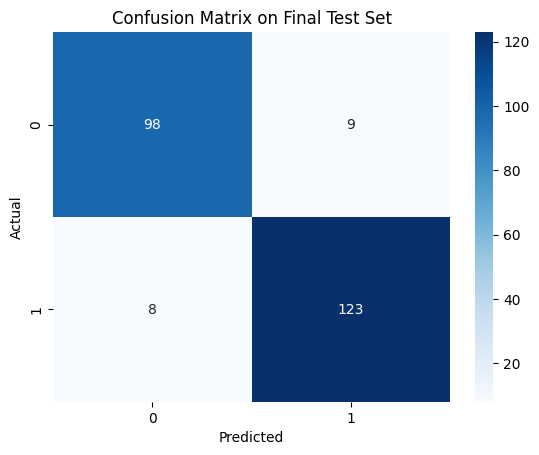

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:\n", classification_report(trues, preds))

# Confusion matrix
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Final Test Set")
plt.show()


In [38]:
import pickle
with open('best_random_forest.pkl', 'wb') as f:
    pickle.dump(final_trees, f)
print("✅ Model saved successfully as 'best_random_forest.pkl'")

✅ Model saved successfully as 'best_random_forest.pkl'
